In [2]:
import numpy as np  
import numpy.random as random 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


# Numerical Modelling Mini-Projects


Abstract: 

In this report, we investigate approaches for modelling complex problems that are found in Physics. The two problems modelled here are the Travelling Salesman and the Tacoma Bridge. The approaches investigated are pairwise exchange with simulated annealing for the Travelling Salesman and Taylor's method combined with Cromer's modification for the Tacoma Bridge. The investigation demonstrates the utility of these approaches and gives examples of their use.



## Introduction

Optimisation is a key component of many physical studies. While computers have made modelling problems vastly easier than it was in the past, they still have their limitations. Some problems with small time complexity can be solved relatively easily but others may have polynomial, exponential or other advanced time complexity that requires computers to spend more and more time on them. This creates a pressing need to optimise problems so they can be computed more easily. This is often done by using heuristics (mild simplifications of a problem and introduction of useful assumptions) so as to eliminate unnecessary calculations in the model [1]. Alternatively, an approximation of a problem might be made to get a 'near enough' answer without having to calculate the problem in its entirety [2].

In this report, we investigate a heuristic algorithm for the well-known Travelling Salesman problem and an approximation for the equations governing the Tacoma Bridge. With the Travelling Salesman, we find that the algorithm employed produces very efficient if not perfect solutions. With the Tacoma Bridge, we find that the approximation of the problem is sufficient to gain insight into the solution.


## The Travelling Salesman

The Travelling Salesman Problem (TSP) imagines a salesman with a list of cities to visit. The goal of the problem is to visit all of these cities as efficiently as possible by optimising the path taken between them [3]. The problem has obvious applications in logistics, where many locations may need to be connected as optimally as possible to save on costs. However, the problem has many other applications obtained by replacing the cities with other points that need connecting. One example is stars in the sky that a telescope needs to move between while minimising time spent not observing anything. More abstractly, the positions from which a detector measures signals in X-Ray crystallography can be optimised with the TSP to reduce the time between measurements (useful when there can be hundreds of thousands of positions needing to be visited in some experiments) [4].

The heuristic method for solving the TSP investigated in this report is a combination of pairwise exchange and simulated annealing. Pairwise exchange is the simple process of randomly swapping pairs of cities in the path to create new paths. Named for the metallurgic heat treatment used to improve ductility of a metal, simulated annealing is a statistical approach to avoiding local minima [5].

A simple pairwise exchange approach to the TSP would be to randomly swap pairs of cities in the path and comparing the length of the path after the swap to before it. If the new path is shorter than the old one, we would accept the swap and repeat the process until we are satisfied we have an optimal path. The problem with this approach would be the danger of local minima. It is possible to have a path where no available swaps would improve the length of the path but a more optimal path does exist. To avoid this potential pitfall, we use simulated annealing. In this approach, we occasionally (according to a probability function) accept a swap that is detrimental to the length of the path. This was we can escape local minima and hopefully find a new way to get to the optimal path.

However, once we have improved our path significantly, accepting a damaging swap could ruin all of our work. Therefore we introduce a temperature function to mediate the acceptance probability. Initially this temperature would be very high, leading to us accepting lots of negative swaps. Then, as more and more swaps take place, we reduce the value of the temperature to so that only smaller detrimental swaps are accepted. Eventually, the temperature would get so low that we would only accept swaps which are likely to improve the path.

This approach is not immune to local minima, in fact they are still a very common endpoint with large numbers of points. We are far more likely to get close to the optimal path though. To account for this, we run the algorithm many times to try and get as close to the optimal path as possible.

In this investigation, we used a set of 30 United States State Capitals arrayed across the Continental US. We implemented a version of the pairwise exchange algorithm utilising simulated annealing and demonstrated that this found a reasonable optimal path between the cities.

Below is code used for displaying the results of the algorithm:

In [63]:
# Code for displaying the path
import json
import copy

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

map = mpimg.imread("map.png")  # Import the United States map

with open('capitals.json', 'r') as capitals_file: # Import the list of capitals
    capitals = json.load(capitals_file)

capitals_list = list(capitals.items())

capitals_list = [(c[0], tuple(c[1])) for c in capitals_list] # Cities are stored as tuples

def coord(path): # Separates the coords (Stored as a tuple) from the city name for a single city tuple
        _, coord = path
        return coord

def coords(path): # Separates the coords (Stored as a tuple) from the city name for a list of cities
        _, coords = zip(*path)
        return coords
    
def show_path(path_, starting_city, w=35, h=15): # Displays the path between cities on a map of the United States
    path=coords(path_);
    x, y = list(zip(*path))
    
    _, (x0, y0) = starting_city
    
    plt.imshow(map);
    plt.plot(x0, y0, 'y*', markersize=15);  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1]);  # include the starting point at the end of path
    plt.axis("off");
    fig = plt.gcf();
    fig.set_size_inches([w, h]);

The temperature function used to determine the probability of accepting a bad swap at different times in the algorithm should decay over time. This can be either exponential, linear or some other function depending on the desired decay. In the rest of the report, exponential decay was favoured. However, linear decay was also investigated:

In [7]:
def expTemp(t, decay = 0.95, T0 = 100000000): # Exponential temperature decay function
    return (decay**t) * T0

def linTemp(t, decay = 1, T0 = 100): # Linear temperature decay function
    return T0 - decay*t # Decay constant here represents the gradient of the graph

The temperature functions over time are shown below for both linear and exponential functions as well as for different decay constants. I decided to stick with exponential decay in the rest of the report as it did not have the added difficulty of possibly going below 0 that linear decay had.

In [30]:
temps95E = []
temps90E = []
temps98E = []
temps100L = []
temps150L = []
temps50L = []
times = []
for i in range(100): # Simulate 100 iterations of temperature decay
    temps95E.append(expTemp(i))
    temps90E.append(expTemp(i, decay = 0.9))
    temps98E.append(expTemp(i, decay = 0.98))
    temps100L.append(linTemp(i))
    temps150L.append(linTemp(i, decay = 1.5))
    temps50L.append(linTemp(i, decay = 0.5))
    times.append(i)

# Plot temperature decay
plt.subplot(2, 1, 1)
plt.title("Exponential Decay Function")
plt.plot(times, temps95E, label="α = 0.95", color = "blue")
plt.plot(times, temps90E, label="α = 0.90", color = "red")
plt.plot(times, temps98E, label="α = 0.98", color = "green")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend();
plt.figure()
plt.subplot(2, 1, 1)
plt.title("Linear Decay Function")
plt.plot(times, temps150L, label="α = 1.5", color = "red")
plt.plot(times, temps100L, label="α = 1.0", color = "blue")
plt.plot(times, temps50L, label="α = 0.5", color = "green")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend();

The next thing to create was a random starting path of cities from the list. The code to do this is shown below. An important part of the function was making sure that a city wasn't selected twice to ensure that all the cities in the list were unique. The number of random cities in the list was also able to be set in the parameters so that smaller lists could be made for testing.

In [9]:
def randPath(numCities):
    capList = [] # List of cities
    rands = [] # List of random numbers
    while True: # Continue selecting random numbers until enough unique ones are selected
        rand = np.random.randint(len(capitals_list))
        if len(rands) == numCities: # If already selected enough random numbers, stop
            break
        elif rand not in rands: # If random number not already selected
            rands.append(rand)
            capList.append(capitals_list[rand])
    return capList

An example list of cities is shown below:

In [10]:
print(randPath(8))

[('Sacramento', (68.4, 254.0)), ('Baton Rouge', (489.6, 442.0)), ('Harrisburg', (670.8, 244.0)), ('Des Moines', (447.6, 246.0)), ('Saint Paul', (451.6, 186.0)), ('Trenton', (698.8, 239.6)), ('Oklahoma City', (392.8, 356.4)), ('Boston', (738.4, 190.8))]


The last bit of setup was to find the length of a path of cities. This is done in the function below:

7141.0489888789225


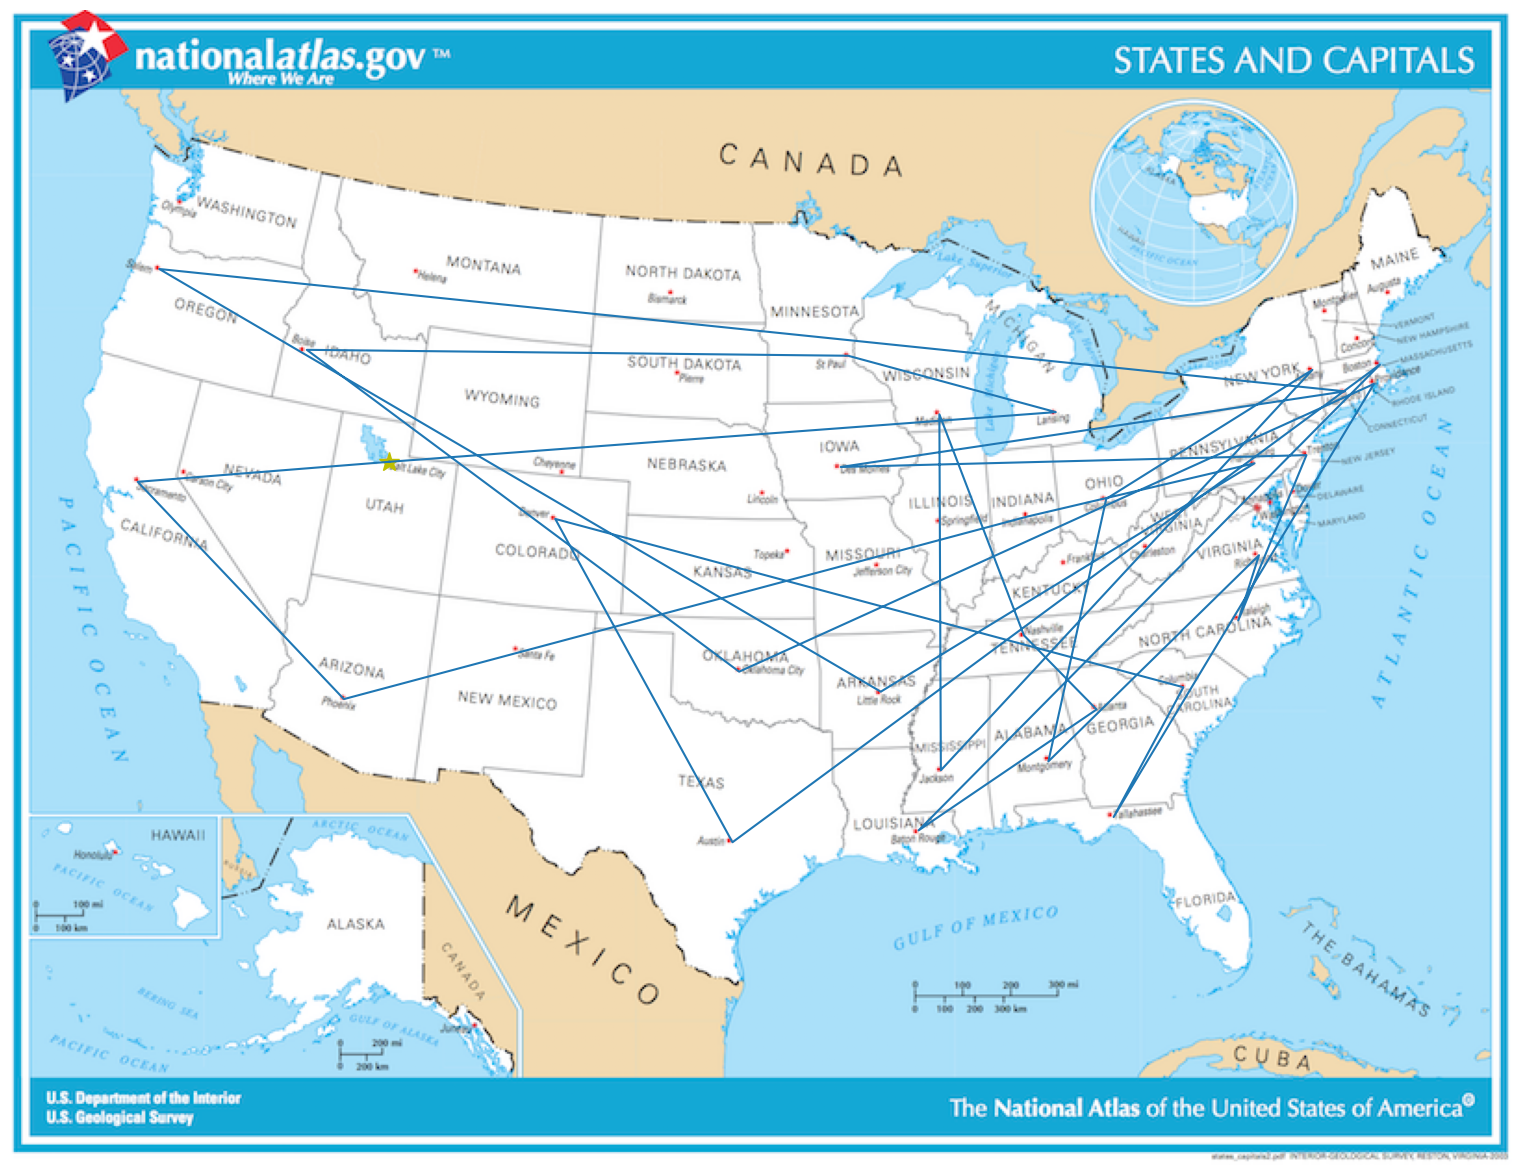

In [62]:
def pathLength(cityPath):
    roundList = list(coords(cityPath)) + [ coord(cityPath[0]) ] # Convert the path into a list of coordinates and add the starting city to the end of the list
    pairList = zip( roundList, roundList[1:] ) # Separate this into pairs of consecutive coordinates
    length = 0 # Initialise the length
    for i in pairList: # Loop through pairs
        length += np.sqrt((i[0][0]-i[1][0])**2 + (i[0][1]-i[1][1])**2) # Pythagoras to work out length of this leg of path added to total length
    return length

testPath = randPath(30)
show_path(testPath, testPath[0])
print(pathLength(testPath))

Using this function and the function for generating random paths, it can be seen that random paths between the 30 cities average ~7000 units in length. With all the setup code finished, next was the actual algorithm of pairwise exchange. Firstly, a function to swap the cities in the list was needed. This was a relatively simple function

In [12]:
def pairSwap(swapPath, swapPos1, swapPos2):
    path = swapPath.copy()
    pos2Copy = path[swapPos2] # Store the second city to be swapped
    path[swapPos2] = path[swapPos1] # Copy the first city to the second city
    path[swapPos1] = pos2Copy # Replace the first city with the copy of the second
    return path

An example of this working is shown below. The final path has the cities in the 2nd and 4th (counting from 0) positions in the initial path swapped.

In [52]:
testPath = randPath(8)
print("Initial path:", testPath)
print()
print("Final Path:", pairSwap(testPath, 2, 4))

Initial path: [('Lansing', (563.6, 216.4)), ('Saint Paul', (451.6, 186.0)), ('Montgomery', (559.6, 404.8)), ('Salem', (80.0, 139.2)), ('Atlanta', (585.6, 376.8)), ('Little Rock', (469.2, 367.2)), ('Boise', (159.6, 182.8)), ('Indianapolis', (548.0, 272.8))]

Final Path: [('Lansing', (563.6, 216.4)), ('Saint Paul', (451.6, 186.0)), ('Atlanta', (585.6, 376.8)), ('Salem', (80.0, 139.2)), ('Montgomery', (559.6, 404.8)), ('Little Rock', (469.2, 367.2)), ('Boise', (159.6, 182.8)), ('Indianapolis', (548.0, 272.8))]


Finally, the function to actually carry out simulated annealing is below. The probability of accepting a swap was

$$ P = e^{ - \left( d_{new} - d_{old} \right) / T } $$

Where any shorter path will have a probability greater than 1 (so is always accepted) and any longer path has a probability between 0 and 1 based on how much longer it is than the old path and what the temperature is at that time. To check whether a path was accepted, a random decimal number between 0 and 1 was selected and compared to the probability. If the random number was less than the probability, it would be accepted, otherwise it would be rejected.

In [17]:
def simAnnealing(startPath, startTemp = 1000, numSwaps = 200, alpha = 0.97):
    temps = [] # Define temps and lengths to record values for the plots
    lengths = []
    path = startPath.copy() # Copy starting path
    temp = startTemp # Copy starting temp
    for i in range(numSwaps): # Loops through for the required number of swaps
        newPath = pairSwap(path, np.random.randint(len(path)), np.random.randint(len(path))) # Swap a random pair of cities
        prob = np.exp(-(pathLength(newPath)-pathLength(path))/temp) # Calculate probability of acceptance
        if np.random.randint(100)/100 < prob: # If random number is less than the probability
            path = newPath.copy() # Copy the new path to the old path
        temp = expTemp(i, alpha, startTemp) # Increment the temperature
        temps.append(temp) # Record the temperature value
        lengths.append(pathLength(path)) # Record the path length
        #print(pathLength(path)) # If interested
    return(path, temps, lengths)

The function did have one issue with calculating the probability, where the decimals of the result become too long to store in a double. This threw a warning but did not impead the function of the algorithm.

Testing this function showed that with smaller paths, it was generally able to reach local minima where no more swaps took place. With more cities, the function could greatly improve the path and sometimes reach a local minimum but sometimes ran out of swaps beforehand. For that reason, the number of swaps and the start temp were increased with more cities.

Below is shown tests with paths containing 8 cities, 20 cities and the full 30 cities. In the graphs shown it is clear that a large randomness is present in the high temperature period but, as the temperature decreases, the paths settle down into minima.

C:\Users\maxor\AppData\Local\Temp\ipykernel_7208\1784864471.py:8: RuntimeWarning: overflow encountered in exp
  prob = np.exp(-(pathLength(newPath)-pathLength(path))/temp) # Calculate probability of acceptance


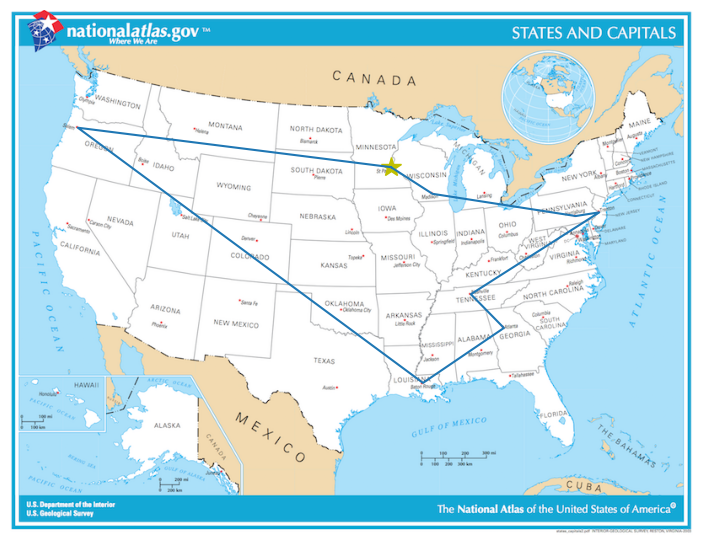

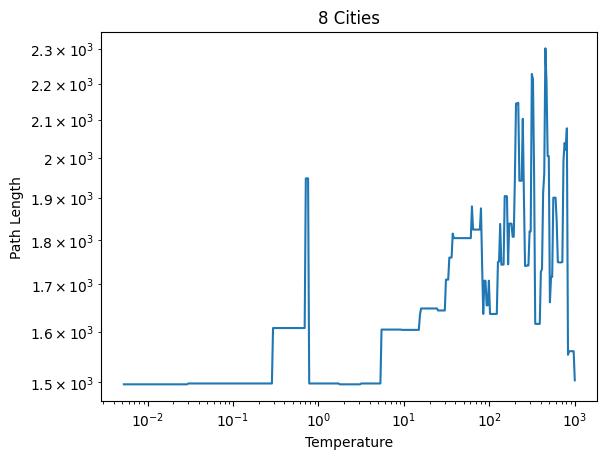

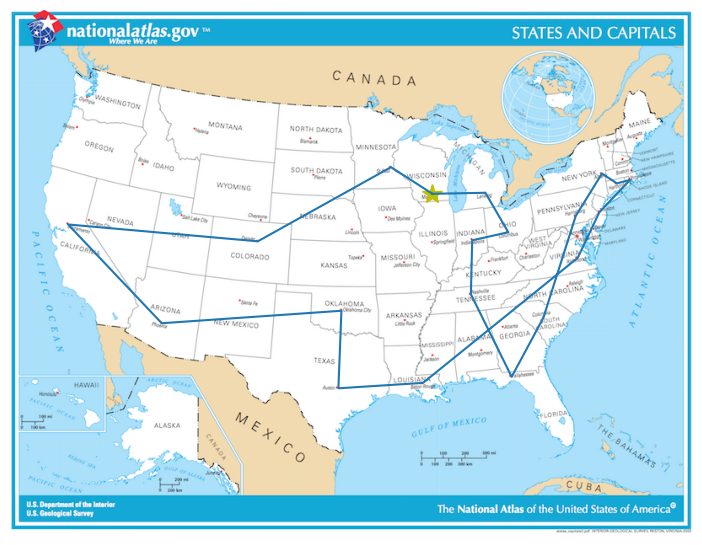

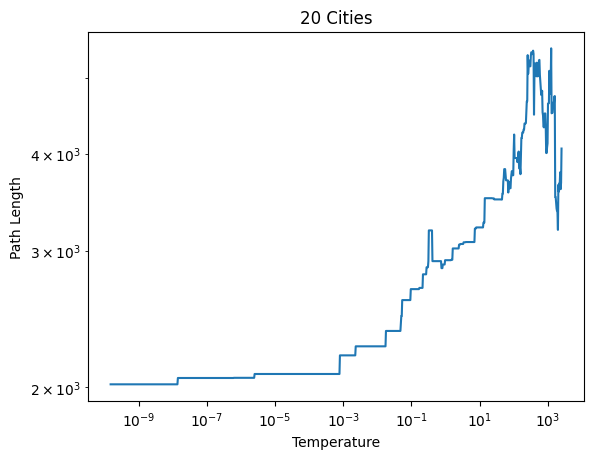

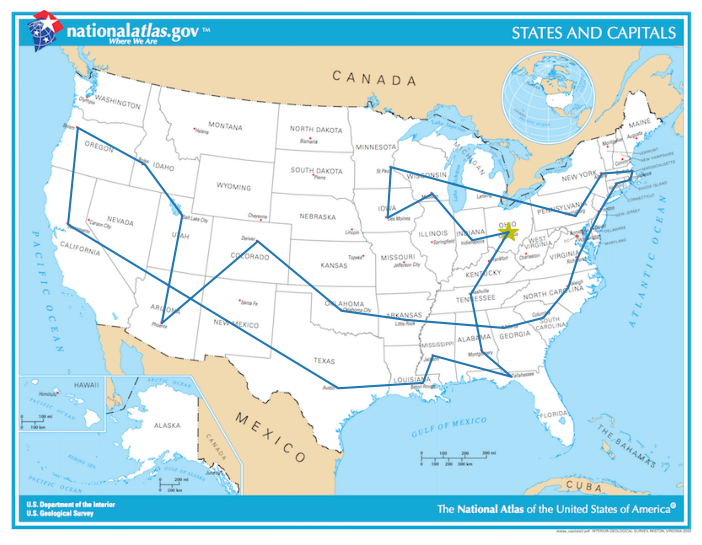

In [58]:
# Testing with 8 cities
path = randPath(8)
plt.subplot(2, 1, 1)
finalPath, temps, lengths = simAnnealing(path, startTemp = 1000, numSwaps = 400, alpha = 0.97)
show_path(finalPath, finalPath[0])
plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature")
plt.ylabel("Path Length")
plt.title("8 Cities")
plt.plot(temps,lengths)
# Start temp of 1000, 200 swaps and 0.9 alpha consistently reaches a local minimum

# Testing with 20 cities
plt.figure()
path = randPath(20)
plt.subplot(2, 1, 1)
finalPath, temps, lengths = simAnnealing(path, startTemp = 2500, numSwaps = 1000, alpha = 0.97)
show_path(finalPath, finalPath[0])
plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature")
plt.ylabel("Path Length")
plt.title("20 Cities")
plt.plot(temps,lengths)
# Start temp of 10000, 1500 swaps and 0.97 alpha consistently reaches a local minimum

# Testing with 30 cities
plt.figure()
path = randPath(30)
plt.subplot(2, 1, 1)
finalPath, temps, lengths = simAnnealing(path, startTemp = 5000, numSwaps = 2000, alpha = 0.97)
show_path(finalPath, finalPath[0])
plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature")
plt.ylabel("Path Length")
plt.title("30 Cities")
plt.plot(temps,lengths);

The last thing to do was try to find an optimal path for the cities in the problem. This meant trying to avoid local minima and get to the shortest possible path length. To do this, the algorithm was repeated many times with the best parameters for the amount of data (found through trial and error). It was unlikely that the algorithm would find the absolute most optimal path but it would obtain a very short path that was close.

C:\Users\maxor\AppData\Local\Temp\ipykernel_7208\1784864471.py:8: RuntimeWarning: overflow encountered in exp
  prob = np.exp(-(pathLength(newPath)-pathLength(path))/temp) # Calculate probability of acceptance


<Figure size 640x480 with 0 Axes>

Shortest path length:  2313.338719243958


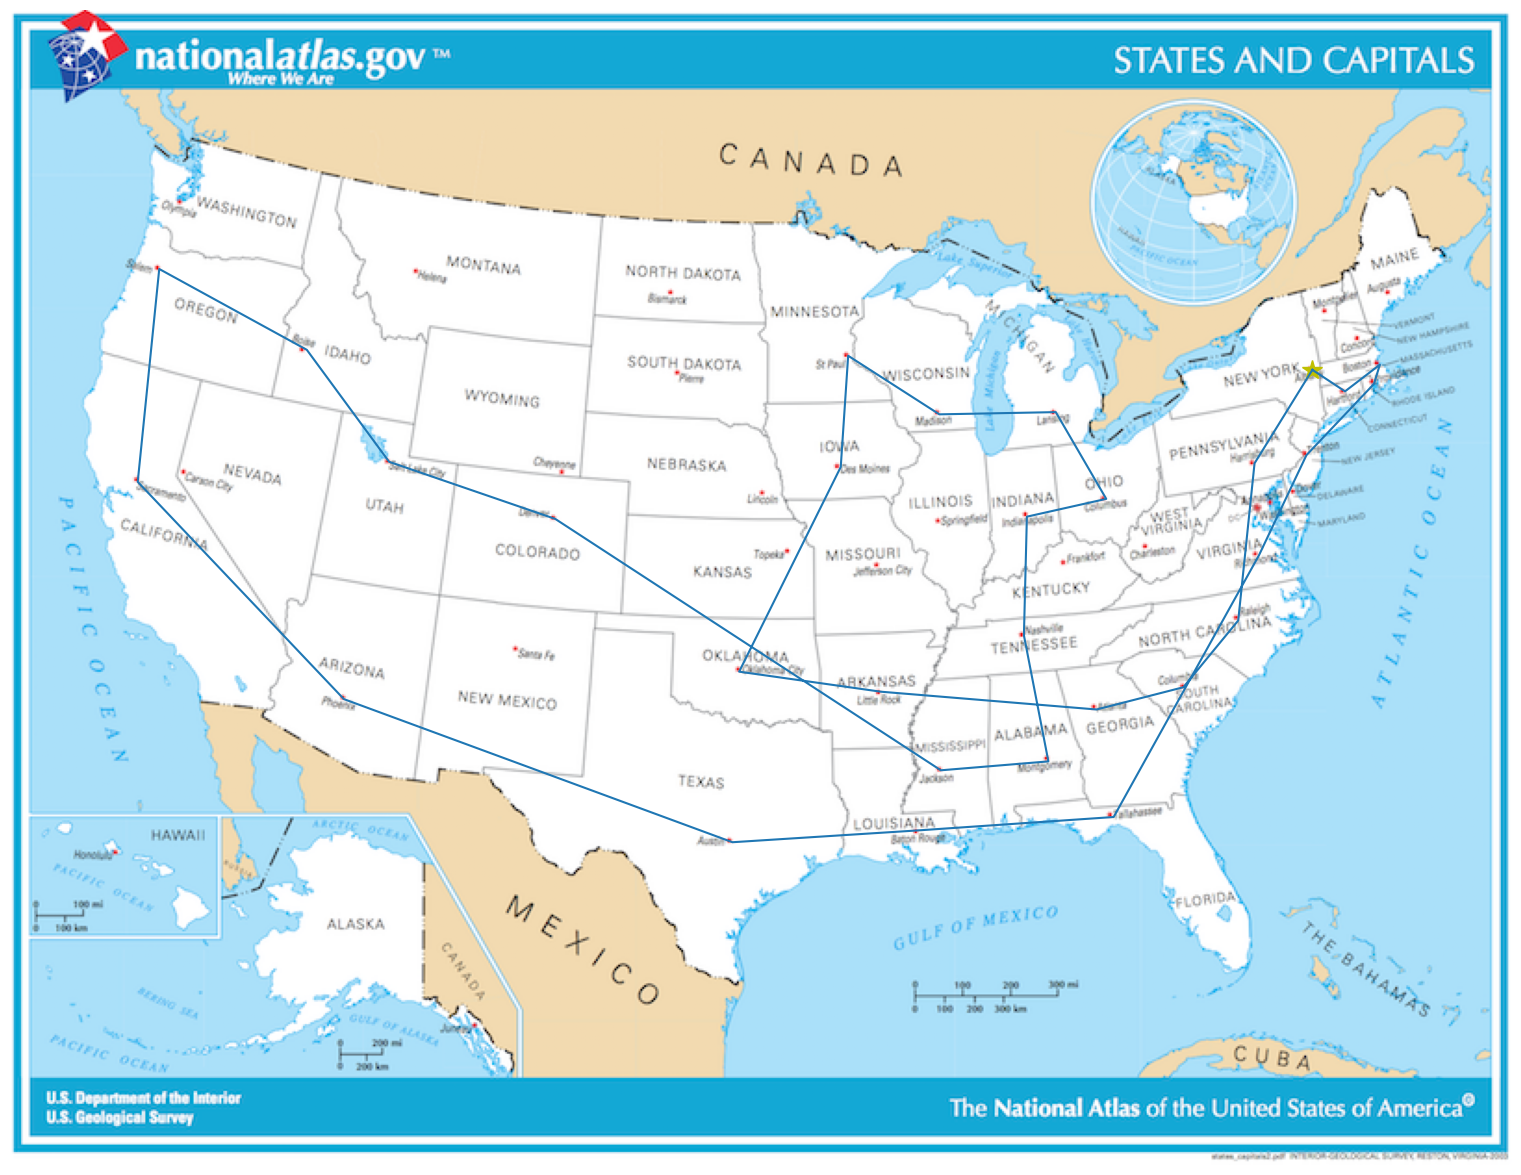

In [50]:
results = []

path = randPath(30) # Create a random path to start with
for i in range(20):
    finalPath, temps, lengths = simAnnealing(path, startTemp = 40000, numSwaps = 6000, alpha = 0.985) # Generate a shortest path
    results.append(finalPath) # Add the generated path to the list
    
    # Determine whether this is the shortest path yet found
    showPath = True
    for j in range(len(results)): # Loop through the found paths
        if(pathLength(finalPath)>pathLength(results[j])): # If this path is longer than any path yet found, it is not the shortest path found
            showPath = False
    if(showPath): # If this is the shortest path yet, record that as i
        pathToShow = i

# Show the shortest path found
plt.figure();
show_path(results[i], results[i][0]);

lengths = []
for i in range(20):
    lengths.append(pathLength(results[i]))
print("Shortest path length: ", lengths[pathToShow]) # Print the length of the path

The shortest path length found out of any run was ~2166 (to the nearest unit). The path was:
Little Rock, Nashville, Jackson, Baton Rouge, Austin, Phoenix, Sacramento, Salem, Boise, Salt Lake City, Denver, Lansing, Albany, Boston, Providence, Hartford, Raleigh, Columbia, Tallahassee, Montgomery, Atlanta, Richmond, Trenton, Harrisburg, Columbus, Indianapolis, Madison, Saint Paul, Des Moines, Oklahoma City.

This is certainly not the optimum path but of all the possible paths it is a very efficient one. To show this, the algorithm was altered to produce the longest possible path instead. This was done by altering the probability of accepting a swap. Instead of always accepting shorter paths and occasionally accepting longer ones, the algorithm would always accept a longer path and sometimes accept a shorter one. The function used to model this probability was:

$$ P = e^{ - ( d_{old} - d_{new} ) / T} $$

This was similar to the original probability function, except now a longer path would have a probability greater than 1 and always be accepted while a shorter path would have a probability of being accepted between 1 and 0.
The code for this is below:

C:\Users\maxor\AppData\Local\Temp\ipykernel_7208\4294382115.py:8: RuntimeWarning: overflow encountered in exp
  prob = np.exp(-(-pathLength(newPath)+pathLength(path))/temp) # Calculate probability of acceptance


10714.275856890516


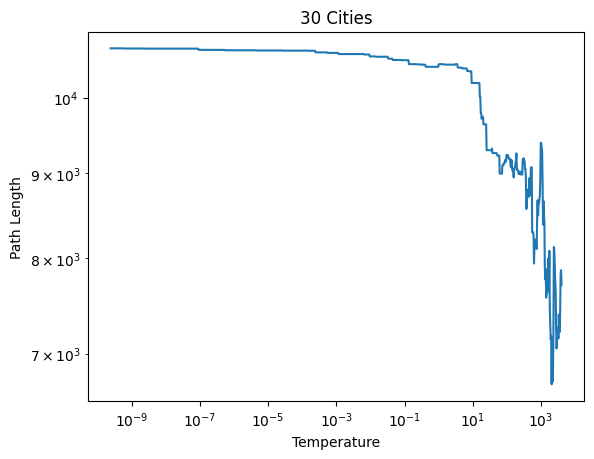

In [59]:
def simAnnealingLong(startPath, startTemp = 1000, numSwaps = 200, alpha = 0.97):
    temps = [] # Define temps and lengths to record values for the plots
    lengths = []
    path = startPath.copy() # Copy starting path
    temp = startTemp # Copy starting temp
    for i in range(numSwaps): # Loops through for the required number of swaps
        newPath = pairSwap(path, np.random.randint(len(path)), np.random.randint(len(path))) # Swap a random pair of cities
        prob = np.exp(-(-pathLength(newPath)+pathLength(path))/temp) # Calculate probability of acceptance
        if np.random.randint(100)/100 < prob: # If random number is less than the probability
            path = newPath.copy() # Copy the new path to the old path
        temp = expTemp(i, alpha, startTemp) # Increment the temperature
        temps.append(temp) # Record the temperature value
        lengths.append(pathLength(path)) # Record the path length
        #print(pathLength(path))
    return(path, temps, lengths)

path = randPath(30)
finalPath, temps, lengths = simAnnealingLong(path, startTemp = 4000, numSwaps = 1000, alpha = 0.97)
print(pathLength(finalPath))
show_path(finalPath, finalPath[0]);
plt.figure();
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature")
plt.ylabel("Path Length")
plt.title("30 Cities")
plt.plot(temps,lengths);

It is clear from the graph that as temperature decreased, the path got as long as possible. The longest path obtained was \~10714 (to the nearest unit). This shows that, while not optimal, the short path length of 2166 was rather efficient compared to the longest possible paths or a random path (\~7000 units).

## The Tacoma Bridge

Constructed in 1940 in the State of Washington, the Tacoma Narrows Bridge was the world's third longest suspension bridge until it collapsed just 3 months after opening. Its collapse is an interesting engineering problem but from a physicial standpoint, it is a good example of how to approximate a system mathematically.

The cause of the collapse was a wind leading to a strong torsional vibration mode causing the deck of the bridge to oscillate violently until it gave way. [6]

The model we used followed two variables: θ, the twisting angle and y, the vertical displacement. The cables of the bridge could have been modelled as springs under Hooke's law, however this would not have been strictly accurate as cables do not remain taught when compressed. Instead we used P. J. Mckenna's model for the force:

$$ F(y) = (k / a) * (e^{ay} - 1) $$

Where a is a force parameter and k is the spring constant of the cables.
The displaced length of the cables on either side is then equal to y - lsinθ and y + lsinθ. This gives rise to two differential equations:

$$ \frac{d^{2}y}{dt^{2}} = - d * \frac{dy}{dt} - \frac{k}{Ma}(e^{a(y - lsin(θ))} + e^{a(y + lsin(θ))} - 2)$$

$$ \frac{d^{2}θ}{dt^{2}} = - d * \frac{dθ}{dt} + \frac{3cos(θ)}{l}\frac{k}{Ma}(e^{a(y - lsin(θ))} - e^{a(y + lsin(θ))})$$

Where M is the mass of the section of the bridge, l is the width of the deck and d is the friction coefficient. We used Taylor's method to approximate these equations to model the behaviour of the bridge.

In Taylor's method, rather than finding an exact solution to the equation, we introduce new variables into our second order differential equations to obtain a system of coupled first order differential equations. This allows us to find the value of our functions at intermediary steps at regular intervals between our start and end points. The spacing between these steps is what determines the accuracy of the approximation (where the limit as the space goes to 0 is the original exact function). The new versions of our equations were:

$$ \frac{dy}{dt} = z $$

$$ \frac{dθ}{dt} = β $$

$$ \frac{dz}{dt} = - d * z - \frac{k}{Ma}(e^{a(y - lsin(θ))} + e^{a(y + lsin(θ))} - 2) $$

$$ \frac{dβ}{dt} = - d * β + \frac{3cos(θ)}{l}\frac{k}{Ma}(e^{a(y - lsin(θ))} - e^{a(y + lsin(θ))})$$

With these equations, the model becomes the following simple functions:

$$ z_{n+1} = z_{n} + Δt*\frac{dz_{n}}{dt} $$

$$ β_{n+1} = β_{n} + Δt*\frac{dβ_{n}}{dt} $$

$$ y_{n+1} = y_{n} + Δt*z_{n} $$

$$ θ_{n+1} = θ_{n} + Δt*β_{n} $$

We can also make use of Cromer's modification that calculates the key variables using the next step's velocities:

$$ z_{n+1} = z_{n} + Δt*\frac{dz_{n}}{dt} $$

$$ β_{n+1} = β_{n} + Δt*\frac{dβ_{n}}{dt} $$

$$ y_{n+1} = y_{n} + Δt*z_{n+1} $$

$$ θ_{n+1} = θ_{n} + Δt*β_{n+1} $$

The implementation of the model is shown below:

In [90]:
# Constant values for the simulation
tstart=0
tend=100

d=0.01
a=1
M=2500
K=10000
l=6


def tacoma(dt=0.01, cromer=False, y0=0, z0=0, theta0=0, beta0=0):
    # Create the variables to store the results
    times=np.arange(tstart, tend+dt, dt)  # Create the array of model times
    Nt=len(times)                         # Number of time-steps

    # Create arrays of 0s for all times
    y=np.zeros(Nt)                    
    theta=np.zeros(Nt)                   
    z=np.zeros(Nt) 
    beta=np.zeros(Nt) 

    # Set the initial conditions
    y[0] = y0
    z[0] = z0
    theta[0] = theta0
    beta[0] = beta0


    # Loop over all of the times and integrate the model
    for n in range(Nt-1):
        # Function for change in z
        dz = -(d*z[n]) - K/(M*a) * (np.exp(a*(y[n] - l * np.sin(theta[n]))) + np.exp(a*(y[n] + l * np.sin(theta[n])))-2)
        z[n+1] = z[n] + dt*dz

        # Function for change in beta
        dbeta = -(d*beta[n]) + (3*np.cos(theta[n])/l) * K/(M*a) * (np.exp(a*(y[n]-l*np.sin(theta[n]))) - np.exp(a*(y[n]+l*np.sin(theta[n]))))
        beta[n+1] = beta[n] + dt*dbeta
    
        
        # Increment angle and vertical displacement using either Cromer's modification or the basic Taylor method
        if cromer:
            y[n+1] = y[n] + dt*z[n+1]
            theta[n+1] = theta[n] + dt*beta[n+1]
        
        else:
            y[n+1] = y[n] + dt*z[n]
            theta[n+1] = theta[n] + dt*beta[n]

    return times, theta, y

This model does not take wind into account and so should show the bridge in a steady state. This is tested by varying the bridge's initial displacement slightly and observing the effect.

With 0 angular displacement, the bridge remains completely still for the duration of the simulation. Then with small initial displacements it oscillates back towards equilibrium. This is true of both the Taylor and Cromer approaches:

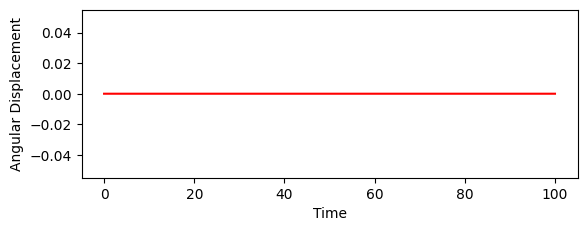

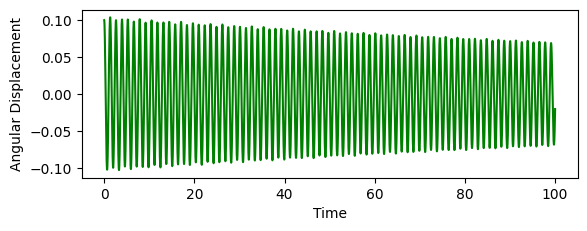

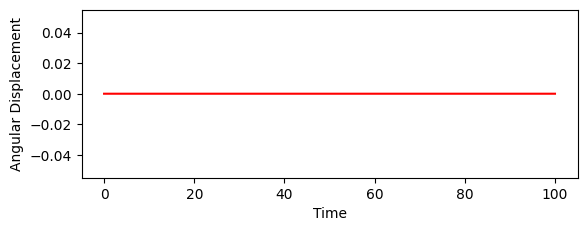

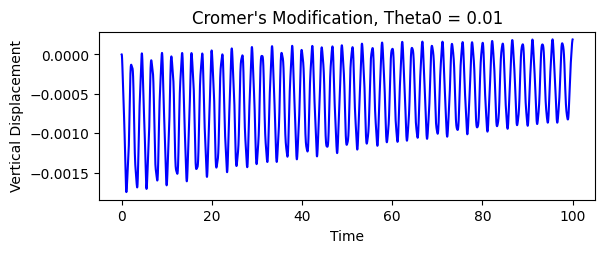

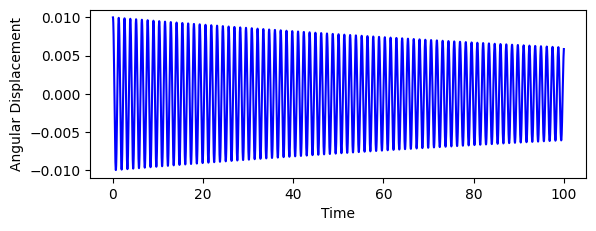

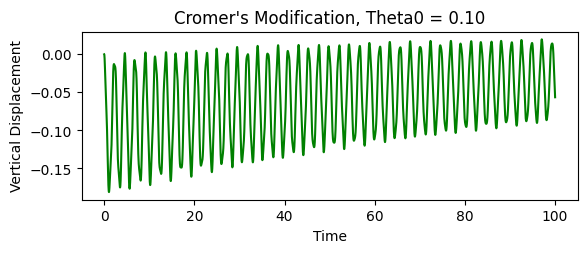

In [84]:
# Plots for Taylor's method
times, theta0, y0 = tacoma(dt = 0.0001, theta0 = 0, cromer = False)
times, theta01, y01 = tacoma(dt = 0.0001, theta0 = 0.1, cromer = False)
times, theta001, y001 = tacoma(dt = 0.0001, theta0 = 0.01, cromer = False)

plt.subplot(2, 1, 2)
plt.title("Taylor's Method, Theta0 = 0.00")
plt.plot(times, y0, color = "red");
plt.xlabel("Time");
plt.ylabel("Vertical Displacement");
plt.figure()
plt.subplot(2, 1, 2)
plt.plot(times, theta0, color = "red");
plt.xlabel("Time");
plt.ylabel("Angular Displacement");

plt.figure()
plt.subplot(2, 1, 2)
plt.title("Taylor's Method, Theta0 = 0.01")
plt.plot(times, y001, color = "blue");
plt.xlabel("Time");
plt.ylabel("Vertical Displacement");
plt.figure()
plt.subplot(2, 1, 2)
plt.plot(times, theta001, color = "blue");
plt.xlabel("Time");
plt.ylabel("Angular Displacement");

plt.figure()
plt.subplot(2, 1, 2)
plt.title("Taylor's Method, Theta0 = 0.10")
plt.plot(times, y01, color = "green");
plt.xlabel("Time");
plt.ylabel("Vertical Displacement");
plt.figure()
plt.subplot(2, 1, 2)
plt.plot(times, theta01, color = "green");
plt.xlabel("Time");
plt.ylabel("Angular Displacement");

# Plots for Cromer's modification
times, theta0, y0 = tacoma(dt = 0.0001, theta0 = 0, cromer = True)
times, theta01, y01 = tacoma(dt = 0.0001, theta0 = 0.1, cromer = True)
times, theta001, y001 = tacoma(dt = 0.0001, theta0 = 0.01, cromer = True)

plt.figure()
plt.subplot(2, 1, 2)
plt.title("Cromer's Modification, Theta0 = 0.00")
plt.plot(times, y0, color = "red");
plt.xlabel("Time");
plt.ylabel("Vertical Displacement");
plt.figure()
plt.subplot(2, 1, 2)
plt.plot(times, theta0, color = "red");
plt.xlabel("Time");
plt.ylabel("Angular Displacement");

plt.figure()
plt.subplot(2, 1, 2)
plt.title("Cromer's Modification, Theta0 = 0.01")
plt.plot(times, y001, color = "blue");
plt.xlabel("Time");
plt.ylabel("Vertical Displacement");
plt.figure()
plt.subplot(2, 1, 2)
plt.plot(times, theta001, color = "blue");
plt.xlabel("Time");
plt.ylabel("Angular Displacement");

plt.figure()
plt.subplot(2, 1, 2)
plt.title("Cromer's Modification, Theta0 = 0.10")
plt.plot(times, y01, color = "green");
plt.xlabel("Time");
plt.ylabel("Vertical Displacement");
plt.figure()
plt.subplot(2, 1, 2)
plt.plot(times, theta01, color = "green");
plt.xlabel("Time");
plt.ylabel("Angular Displacement");



The obvious next step is to introduce the wind that was the downfall of the real Tacoma bridge. This is done by modelling the bridge as a constant vertical force according to:

$$ F_{wind} = MAsin(ωt) $$

Where M is the mass of the bridge, A is the amplitude of the force and ω is the frequency of the force. This can be reduced via Newton's 2nd law to an equation for acceleration:

$$ a_{wind} = \frac{F_{wind}}{M} = Asin(ωt) $$

This can be integrated into the code by simply adding an extra term to the z calculation (dz being the acceleration of y):

In [89]:
def tacomaWind(dt=0.01, cromer=False, y0=0, z0=0, theta0=0, gamma0=0, A=1, omega=3):
    # Create the variables to store the results
    times=np.arange(tstart, tend+dt, dt)  # Create the array of model times
    Nt=len(times)                         # Number of time-steps

    # Create arrays of 0s for all times
    y=np.zeros(Nt)                   
    theta=np.zeros(Nt)                   
    z=np.zeros(Nt) 
    gamma=np.zeros(Nt) 

    # Set the initial conditions
    y[0] = y0
    z[0] = z0
    theta[0] = theta0
    gamma[0] = gamma0


    # Loop over all of the times and integrate the model
    for n in range(Nt-1):
        # Function for change in z including wind acceleration
        dz = -(d*z[n]) - K/(M*a) * (np.exp(a*(y[n] - l * np.sin(theta[n]))) + np.exp(a*(y[n] + l * np.sin(theta[n])))-2) + A*np.sin(omega*n*dt)
        z[n+1] = z[n] + dt*dz
        
        # Function for change in beta
        dgamma = -(d*gamma[n]) + (3*np.cos(theta[n])/l) * K/(M*a) * (np.exp(a*(y[n]-l*np.sin(theta[n]))) - np.exp(a*(y[n]+l*np.sin(theta[n]))))
        gamma[n+1] = gamma[n] + dt*dgamma

        # Increment angle and vertical displacement using either Cromer's modification or the basic Taylor method
        if cromer:
            y[n+1] = y[n] + dt*z[n+1]
            theta[n+1] = theta[n] + dt*gamma[n+1]
        
        else:
            y[n+1] = y[n] + dt*z[n] + A*np.sin(omega*n)
            theta[n+1] = theta[n] + dt*gamma[n]



    return times, theta, y

The amplitude of the wind force has a large effect on the oscillation of the bridge. With a weaker win, angular displacement tends towards smaller oscillations over time wheras a stronger wind creates larger angular oscillations over time.

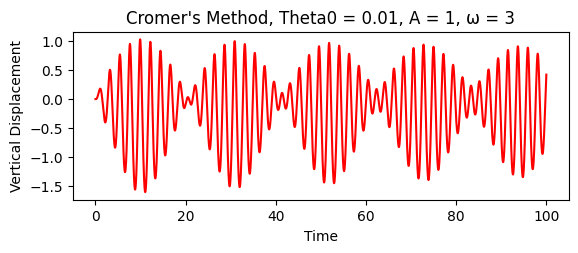

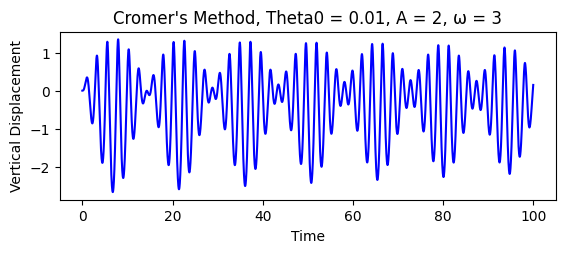

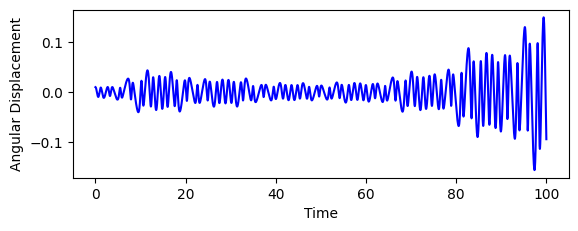

In [91]:
times, theta1, y1 = tacomaWind(dt = 0.0001, theta0 = 0.01, cromer = True, A = 1, omega = 3)
times, theta2, y2 = tacomaWind(dt = 0.0001, theta0 = 0.01, cromer = True, A = 2, omega = 3)

plt.subplot(2,1,2)
plt.title("Cromer's Method, Theta0 = 0.01, A = 1, ω = 3")
plt.plot(times, y1, color = "red");
plt.xlabel("Time");
plt.ylabel("Vertical Displacement");
plt.figure()
plt.subplot(2,1,2)
plt.plot(times, theta1, color = "red")
plt.xlabel("Time");
plt.ylabel("Angular Displacement");

plt.figure()
plt.subplot(2,1,2)
plt.title("Cromer's Method, Theta0 = 0.01, A = 2, ω = 3")
plt.plot(times, y2, color = "blue");
plt.xlabel("Time");
plt.ylabel("Vertical Displacement");
plt.figure()
plt.subplot(2,1,2)
plt.plot(times, theta2, color = "blue")
plt.xlabel("Time");
plt.ylabel("Angular Displacement");

The frequency of the force also has a large impact on the oscillation:

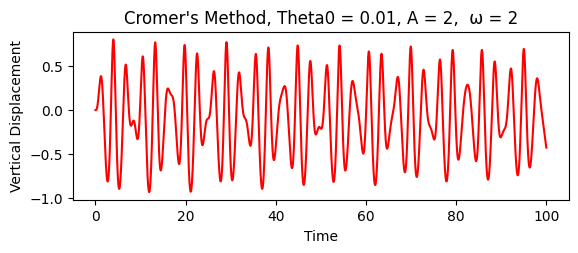

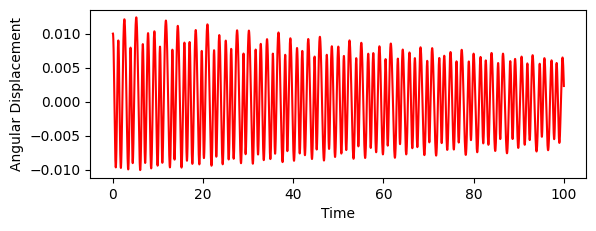

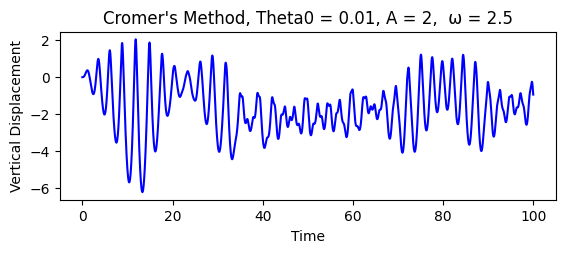

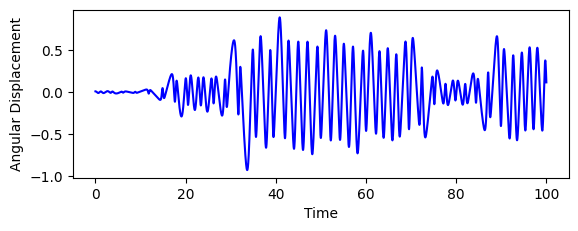

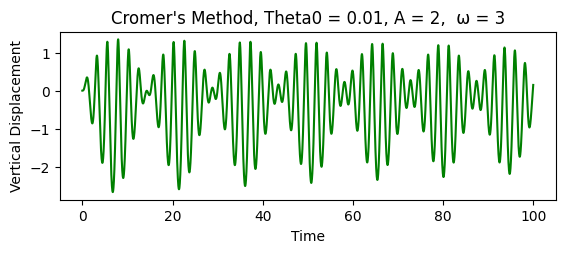

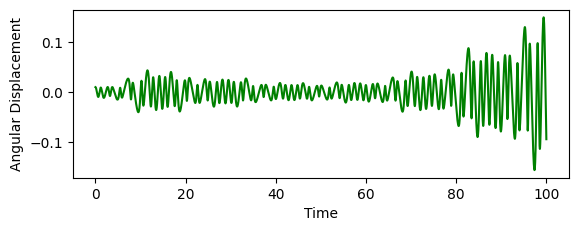

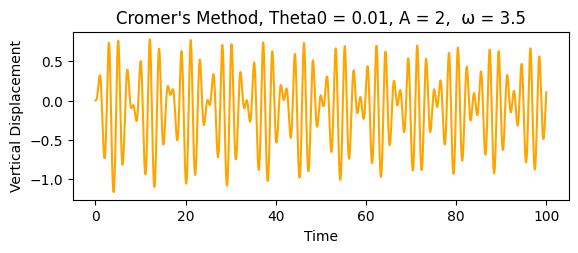

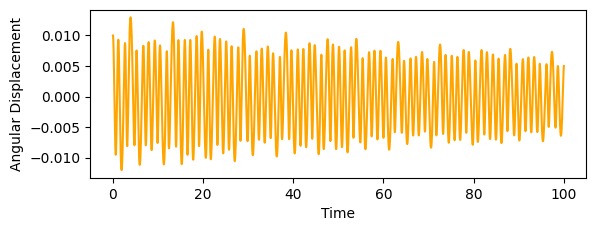

In [133]:
times, theta2, y2 = tacomaWind(dt = 0.0001, theta0 = 0.01, cromer = True, A = 2, omega = 2)
times, theta25, y25 = tacomaWind(dt = 0.0001, theta0 = 0.01, cromer = True, A = 2, omega = 2.5)
times, theta3, y3 = tacomaWind(dt = 0.0001, theta0 = 0.01, cromer = True, A = 2, omega = 3)
times, theta35, y35 = tacomaWind(dt = 0.0001, theta0 = 0.01, cromer = True, A = 2, omega = 3.5)

plt.subplot(2,1,2)
plt.title("Cromer's Method, Theta0 = 0.01, A = 2,  ω = 2")
plt.plot(times, y2, color = "red");
plt.xlabel("Time");
plt.ylabel("Vertical Displacement");
plt.figure()
plt.subplot(2,1,2)
plt.plot(times, theta2, color = "red")
plt.xlabel("Time");
plt.ylabel("Angular Displacement");

plt.figure()
plt.subplot(2,1,2)
plt.title("Cromer's Method, Theta0 = 0.01, A = 2,  ω = 2.5")
plt.plot(times, y25, color = "blue");
plt.xlabel("Time");
plt.ylabel("Vertical Displacement");
plt.figure()
plt.subplot(2,1,2)
plt.plot(times, theta25, color = "blue")
plt.xlabel("Time");
plt.ylabel("Angular Displacement");

plt.figure()
plt.subplot(2,1,2)
plt.title("Cromer's Method, Theta0 = 0.01, A = 2,  ω = 3")
plt.plot(times, y3, color = "green");
plt.xlabel("Time");
plt.ylabel("Vertical Displacement");
plt.figure()
plt.subplot(2,1,2)
plt.plot(times, theta3, color = "green")
plt.xlabel("Time");
plt.ylabel("Angular Displacement");

plt.figure()
plt.subplot(2,1,2)
plt.title("Cromer's Method, Theta0 = 0.01, A = 2,  ω = 3.5")
plt.plot(times, y35, color = "orange");
plt.xlabel("Time");
plt.ylabel("Vertical Displacement");
plt.figure()
plt.subplot(2,1,2)
plt.plot(times, theta35, color = "orange")
plt.xlabel("Time");
plt.ylabel("Angular Displacement");

While the angular displacement is quite chaotic in some instances, the vertical displacement follows a clear pattern. As the frequency of the wind force changes, a sinusoidal pattern in the vertical displacement increases or decreases in frequency. At ω = 3.5, the frequency is ~10 seconds while at ω = 3 it is closer to ~15 seconds. The pattern becomes harder to distinguish at ω = 2.5 and ω = 2 but still clear regions of higher amplitude are separate from areas of low amplitude. This shows the relationship between vertical displacement and the vertical wind force.

To cause the bridge to actually collapse, either the vertical or angular displacement or a combination of the two would have to become too large and produce enough stress to overcome the ultimate tensile strength of the materials used in the bridge's construction.

To show how the frequency of the wind force affected the torsion angle of the bridge, we plotted a heatmap of the torsion angle over time for a range of force frequencies:

In [172]:
import seaborn as s

dataset = []
w = []

for i in range(10):
    times, theta, y = tacomaWind(dt = 0.001, theta0 = 0.01, cromer = True, A = 2, omega = 2 + i/5)
    dataset.append(theta)
    w.append(2+i/5)

hm = s.heatmap(np.array(dataset), xticklabels = 0, yticklabels = w, cmap = "seismic", center = 0)
plt.xlabel("Time (0-100)")
plt.ylabel("ω, Force Frequency")
plt.show();

This shows that there is a set of force frequencies that produce far larger torsion angles than others. The final plot made was of the time trajectory of θ against y for different force frequencies. This plot showed again the frequency region where the largest displacement and torsion angles were created was around ω = 2.5 and decreased either side of that peak (the 2.0 line is very small and hidden behind the others).

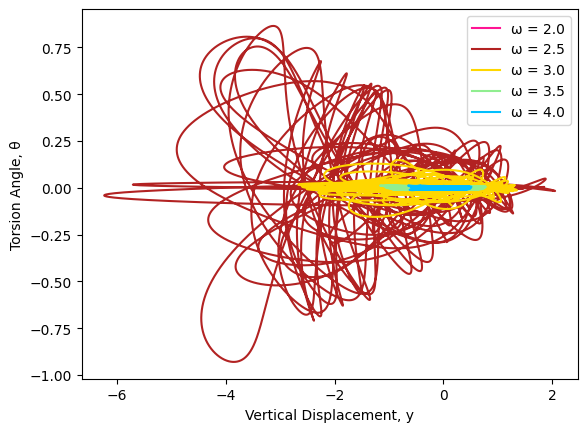

In [208]:
colours = ["deeppink", "firebrick", "gold", "lightgreen", "deepskyblue"]
for i in range(5):
    times, theta, y = tacomaWind(dt = 0.001, theta0 = 0.01, cromer = True, A = 2, omega = 2 + i/2)
    thisLabel = f"ω = {2 + i/2}"
    plt.plot(y, theta, label = thisLabel, color = colours[i])
    plt.xlabel("Vertical Displacement, y")
    plt.ylabel("Torsion Angle, θ")

plt.legend()
plt.show();

Incidentally, the vertical force caused the bridge to oscillate once every two seconds. This gave a value of ω = 2π/2 ≈ 3, very near the region that creates large torsion angles. No wonder the bridge collapsed.

## Conclusion

This report has described a thorough investigation of some common optimisation techniques for two well known problems.

In the TSP, we showed how using a simple algorithm with some basic assumptions about minima can produce a very efficient solution to a potentially complex problem. With the Tacoma Bridge, we have shown that approximating a problem can give valuable insights into the way the problem works, in this case the relationship between the wind and the displacement of the bridge. These sorts of approaches are vital to all manner of real world problems and modelling tasks, as described in the introduction.

Both investigations could be extended further. The algorithm used for the TSP becomes inefficient when larger numbers of cities are added to the path. Investigating approaches to larger paths would be a fruitful area of research. Alternatively, it might be worth investigating what other heuristics could be implemented (e.g. the no-cross rule which most humans understand implicitly when solving Travelling Salesman-like problems [7]). With respect to the Tacoma Bridge problem, the bridge has been modelled here as a single 2-dimensional section while in the real world it is obviously a 3-dimensional object. Improving the model so that consecutive sections interact with each other would be a good extension.

## References

[1] : David Myers, Social Psychology, McGraw-Hill Companies 2009

[2] : R. E. Allen, H. W. Fowler, F. G. Fowler, The Concise Oxford Dictionary of Current English, Clarendon Press 1990

[3] : Julia Robinson, On the Hamiltonian Game (A Traveling Salesman Problem), Rand Corporation 1949

[4] : R. Matai, S. P. Singh, M. L. Mittal, Traveling Salesman Problem, InTech 2010

[5] : D. Ferrer Balas, Influence of annealing on the microstructural, tensile and fracture properties of polypropylene films, Polymer 2001

[6] : G. Arioli, F Gazzola, A mathematical explanation of what triggered the catastrophic torsional mode of the Tacoma Narrows Bridge,         Applied Mathematical Modelling 2013

[7] : I. V. Rooij, U. Stege, A. Schactman, Convex hull and tour crossings in the traveling salesperson problem, Memory & Cognition 2003s 


---